# Big Iron

See <a href="https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard">Blue Book for Bulldozers</a> leaderboard page.

BTW this notebook borrows heavily from <a href="https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb">chapter 9</a> of
<a href="https://github.com/fastai/fastbook">Fastai's FastBook.
    
<mark>Fastai also has a set of <a href="https://www.fast.ai/posts/2022-07-21-dl-coders-22.html">online courses</a> and librarys (see below) designed to show regular people how to apply advanced machine and deep learning algorithms to real world problems.  Its extremely applied and fortunately, much of the complexity is handled by the library itself.  
    
<b>It is the best course I know of for teaching AI, Machine Learning and Data Science.

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    
import utils as ut

#want to use a subset of the data?
use_latest=False
latest_size=200000

<mark>install fastai

In [325]:
#install fastai library
# !pip install fastai
#or see https://pypi.org/project/fastai/

# Get the data

In [326]:
#install kaggle api
# !pip install kaggle

In [327]:
#if you have the Kaggle api installed then use it
# !kaggle competitions download -c bluebook-for-bulldozers

In [328]:
#uhoh...my key is exposed, get your key from kaggle place it in the noted folder
# !chmod 600 /home/keith/.kaggle/kaggle.json

# EDA

In [329]:
df=pd.read_csv('./data/TrainAndValid.csv')
print(df.shape)

(412698, 53)


/tmp/ipykernel_74093/1701633161.py:1: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./data/TrainAndValid.csv')


In [330]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Note the sale date, this is a time series problem, that changes how we split the data into train and validation set (cannot use random splitter)

To split: Older data is training data, Newer data is validation data.  This keeps information from leaking from the validation set back to the training set.

### Lets see what the date range is

In [331]:
df['saledate']=pd.to_datetime(df['saledate'])

In [332]:
print(f'earliest date= {df.saledate.min()}, latest date={df.saledate.max()}')

earliest date= 1989-01-17 00:00:00, latest date=2012-04-28 00:00:00


### Sort the dataframe by saledate in preparation for splitting into train and validation sets
<mark> train on oldest, test on newest

In [333]:
df.sort_values(by=['saledate'], inplace=True)

if(use_latest):
    df=df[-latest_size:]
len(df)

412698

### Add a Time field for the Linear regressor that we will use to subtract the trend

In [334]:
dates=pd.DatetimeIndex(df.saledate)
df['Time']=[(dates[i]-dates[0]).days for i in range(len(df))]

# df[['saledate','Time']].head(20)

## <mark>Hmmm.. this dataset has sales around 2007, when the almost great depression hit

I wonder if a vix entry would help?  Goto <a href="https://www.macrotrends.net/2603/vix-volatility-index-historical-chart">VIX Volatility Index - Historical Chart</a> to grab this data, get all years and download the csv.  See if it helps, if so keep it, if not dont.
    
While we are at it. Lets get a few more: 
    
1.<a href="https://www.macrotrends.net/2534/wheat-prices-historical-chart-data">Wheat Prices - 40 Year Historical Chart</a><br>
2.<a href="https://www.macrotrends.net/2015/fed-funds-rate-historical-chart">Federal Funds Rate - 62 Year Historical Chart</a>  

In [335]:
#create a little function to preprocess, scale and add to df
from sklearn.preprocessing import StandardScaler
def get_df(df,filename,new_col_name):
    dfn=pd.read_csv(filename,skiprows=15)
    dfn['date'] =  pd.to_datetime(dfn['date'])
    dfn.rename(columns={' value':new_col_name},inplace=True)
    
    #scale it
    dfn[new_col_name]=StandardScaler().fit_transform(dfn[[new_col_name]])
    
    #now merge
    df = pd.merge(df,dfn, left_on='saledate', right_on='date', how='left')
    df.drop(columns=['date'],inplace=True)
    df[new_col_name].fillna(method='backfill',inplace=True)
    df[new_col_name].fillna(method='ffill',inplace=True)
    return df

# df=get_df(df,'./vix-volatility-index-historical-chart.csv','vix')
# df=get_df(df,'./wheat-prices-historical-chart-data.csv','wheat')
# df=get_df(df,'./fed-funds-rate-historical-chart.csv','fedrate')

### <mark>Split Dates into more useful features

Its hard for a random forest to use a datetime object since it has a lot of encoded information (the year,the month, the day of the week, weekday, weekend, holiday, end of quarter etc.).  We can slog through and manually create these features, or use fastai, a library that already does this.

In [336]:
#using a fastai helper function to get ALL the date info
from fastai.tabular import core
df = core.add_datepart(df, 'saledate')

#look at all those additional sale columns
[col for col in df.columns if 'sale' in col]

['saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

Any obvious outliers?

In [337]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,Time,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,4.126980e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03,5754.079366,2004.317382,6.300268,25.721191,16.152894,2.594338,176.784094,1.098151e+09
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04,2123.225527,5.821090,3.437276,14.841265,8.429510,1.417971,103.910718,1.834467e+08
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,1989.000000,1.000000,1.000000,1.000000,0.000000,1.000000,6.009984e+08
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,4341.000000,2000.000000,3.000000,12.000000,9.000000,2.000000,82.000000,9.760608e+08
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,6371.000000,2006.000000,6.000000,24.000000,16.000000,3.000000,165.000000,1.151453e+09
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03,7436.000000,2009.000000,9.000000,39.000000,23.000000,3.000000,270.000000,1.243469e+09
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,8502.000000,2012.000000,12.000000,53.000000,31.000000,6.000000,365.000000,1.335571e+09


### <mark>YearMade has some tractors made in the year 1000, how to fix this?

<AxesSubplot:xlabel='YearMade', ylabel='Count'>

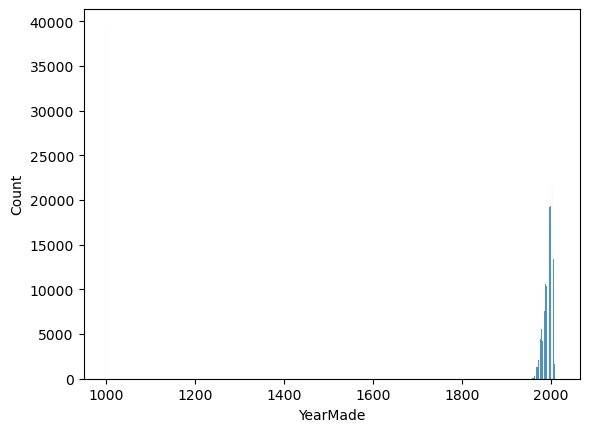

In [338]:
sns.histplot(df,x='YearMade')

In [339]:
#how many made before 1950?
n=df.loc[df.YearMade<1950]
n.shape[0]

39542

### Maybe we can use groupby to infer the incorrect YearMades?

In [340]:
#look for good columns to groupby, dont use ones with a lot of NaNs

# df.nunique().sort_values()
# df.select_dtypes(include=['object'])
# df.select_dtypes(include=['object']).dtypes

#find good columns to groupby
tmp=df.loc[:,['fiModelDesc','ModelID','fiBaseModel','fiModelSeries','fiModelDescriptor','fiProductClassDesc']]

#want few nulls
tmp.isnull().sum()

fiModelDesc                0
ModelID                    0
fiBaseModel                0
fiModelSeries         354031
fiModelDescriptor     337882
fiProductClassDesc         0
dtype: int64

In [341]:
#ok no 'fiModelSeries','fiModelDescriptor'
tmp=tmp.drop(columns=['fiModelSeries','fiModelDescriptor'])

In [342]:
def impute_YearMade(df,year=1950):
    '''
    replace any YearMade<year with the max for the below groupby or year

    df: dataframe to impute YearMade on
    year: anything below this year is imputed, if cannot be imputed set to year
    '''
    #lets try fiBaseModel and fiProductClassDesc for mean YearBuilt
    estimates=df.groupby(['fiModelDesc','fiProductClassDesc']).YearMade.max()
    
    #for a given row, look up and return the mean YearMade
    def impute_yb(x):
        est=estimates[(x['fiModelDesc'],  x['fiProductClassDesc'])]
        if est is np.nan or est < year:
            est=year
        return est
  
    df['YearMade']=df.apply(lambda x:impute_yb(x) if x.YearMade<year else x.YearMade,axis=1)   
    return df

In [343]:
df=impute_YearMade(df)

### See what the most sales dates are

<AxesSubplot:>

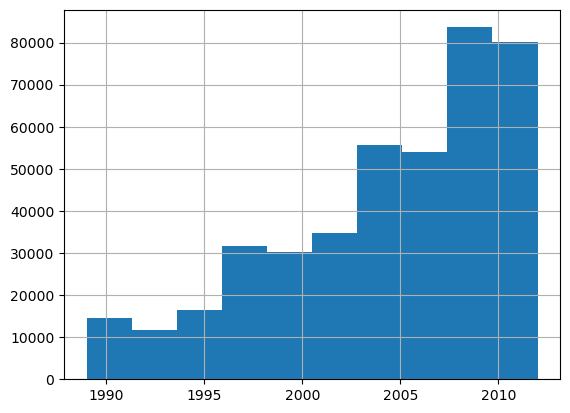

In [344]:
df.saleYear.hist()

### Maybe the older data is not as relevant?  Drop everything <2004

Also not as much of it

In [345]:
filt=df['saleYear']>2004
df=df[filt]

In [346]:
df.shape

(238132, 66)

## Prepare the rest of the data (the super easy way)

Use FastAI's TabularPandas class to prepare data

### Dependant var

We are trying to predict 'SalePrice'.  Specifically the root mean squared log error (RMSLE) between the actual and predicted values.  Start by taking the log of the dependant variable (the L of RMSLE) 

In [347]:
dep_var = 'SalePrice'
#take the log of dependant var since that is what the contest wants
df[dep_var] = np.log(df[dep_var])

## Get the indexes of train and test

Its a time series, the latest entries are the test set, the earlier ones, the train set.  Everything later than Oct 2010 is test

In [348]:
cond = (df.saleYear<2012 )
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

### What do they look like BTW

Lets also see what the vix and some commodity prices are

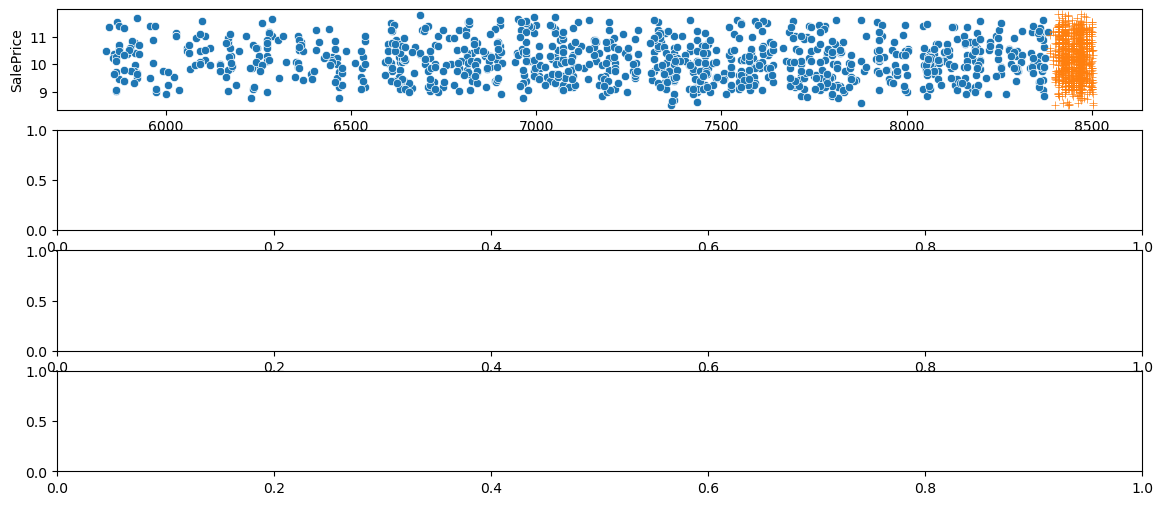

In [349]:
# trn_subset=train_idx[-500:]
# valid_subset=valid_idx[:500]
trn_subset=train_idx
valid_subset=valid_idx
trn_and_valid_subset=np.append(trn_subset,valid_subset)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,figsize=(14,6))

# the following 2 take a long time to plot we only want to see where they begin and end
trn_subset = np.random.choice(trn_subset, 1000)
valid_subset=np.random.choice(valid_subset, 1000)
_=sns.scatterplot(x=df.iloc[trn_subset].Time, y=df.iloc[trn_subset].SalePrice,ax=ax1,  marker="o")
_=sns.scatterplot(x=df.iloc[valid_subset].Time, y=df.iloc[valid_subset].SalePrice,ax=ax1,  marker="+")

# _=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].vix,ax=ax2,  marker="+")
# _=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].wheat,ax=ax3,  marker="o")
# _=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].fedrate,ax=ax4,  marker="o")

### Obvious ordinal Categorical

In [350]:
df['ProductSize'].unique()

array(['Large / Medium', 'Medium', 'Small', nan, 'Mini', 'Large',
       'Compact'], dtype=object)

In [351]:
szs=[ 'Large','Large / Medium','Medium','Compact','Small','Mini']
szs_to_i={i:v for v,i in enumerate(szs)}
df['ProductSize'] = df['ProductSize'].map(szs_to_i)

### <mark>What are the other categorical and the continuous variables?

Easy to ID: cat columns are objects or ints with small cardinality, continuous are ints with large cardinality or floats.  

We can get this easily using dtypes and nunique, or we can use a fastai function that does it for us in 1 go.

In [352]:
# using these? 
# df.dtypes
# df.SalesID.nunique()

In [353]:
from fastai.tabular.all import *
cont,cat = cont_cat_split(df,max_card=1, dep_var=dep_var)

### Some transforms for the data

In [354]:
from fastai.tabular.all import *

#Categorify transform- replaces a column with a numeric categorical column
#FillMissing - replaces missing values with median for the column and creates 
#a new Boolean column that is set to True for any row where the value was missing. 
procs = [Categorify, FillMissing]

## Now lets create a TabularDataFrame that will autotransform columns for our model

Its mostly a wrapper around a DataFrame that does some work for us

In [355]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [356]:
len(to.train),len(to.valid)

(226559, 11573)

In [357]:
#strings still displayed
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,ProductSize_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,ProductSize,Time,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
10704,Medium,EC280LC,EC280,#na#,#na#,LC,"Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons",Connecticut,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,Manual,#na#,#na#,#na#,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,1174825,1056544,22911,121,3.0,1998,4401.0,1.0,5837,2005,1,2,10,0,10,1.105315e+09,11.018629
10644,Low,980B,980,B,#na#,#na#,Wheel Loader - 275.0 to 350.0 Horsepower,California,WL,Wheel Loader,#na#,OROPS,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,1174686,1038563,3876,121,3.0,1970,3067.0,2.0,5838,2005,1,2,11,1,11,1.105402e+09,9.132379
10646,Medium,315L,315,#na#,#na#,L,"Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons",New Jersey,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,Steel,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,1174694,1018458,1133,121,3.0,1995,7835.0,4.0,5840,2005,1,2,13,3,13,1.105574e+09,10.545341
10727,Medium,416C,416,C,#na#,#na#,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,North Carolina,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,True,1174885,112264,3538,121,3.0,2000,2312.0,2.0,5840,2005,1,2,13,3,13,1.105574e+09,10.126631
90708,#na#,226,226,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,Unspecified,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,True,True,1399078,1398984,7009,132,3.0,2002,0.0,2.0,5840,2005,1,2,13,3,13,1.105574e+09,9.510445


In [358]:
#grab the DataFrame though and you see that its been transformed
to.items.head()
# type(to.items)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Time,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,ProductSize_na
10704,1174825,11.018629,1056544,22911,121,3.0,1998,4401.0,3,2339,710,0,0,64,1.0,16,7,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,2,0,0,0,2,19,28,3,2,1,0,0,0,0,0,5837,2005,1,2,10,0,10,1,1,1,1,1,1,1.105315e+09,1,1,1
10644,1174686,9.132379,1038563,3876,121,3.0,1970,3067.0,2,1652,493,21,0,0,2.0,67,5,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,16,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,5838,2005,1,2,11,1,11,1,1,1,1,1,1,1.105402e+09,1,1,1
10646,1174694,10.545341,1018458,1133,121,3.0,1995,7835.0,3,486,164,0,0,63,4.0,9,30,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,7,28,3,2,1,0,0,0,0,0,5840,2005,1,2,13,3,13,1,1,1,1,1,1,1.105574e+09,1,1,1
10727,1174885,10.126631,112264,3538,121,3.0,2000,2312.0,3,674,218,30,0,0,2.0,2,33,1,1,4,6,2,2,1,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5840,2005,1,2,13,3,13,1,1,1,1,1,1,1.105574e+09,1,1,2
90708,1399078,9.510445,1398984,7009,132,3.0,2002,0.0,0,305,100,0,0,0,2.0,39,45,3,3,0,6,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,5840,2005,1,2,13,3,13,1,1,1,1,1,1,1.105574e+09,1,2,2


## Lets get our train and test sets

In [359]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [360]:
#dataset for the linear regressor part of the BoostedHybrid model
xs_linreg=xs.loc[:,['Time']]
valid_xs_linreg=valid_xs.loc[:,['Time']]

# Train model

The same one we have been using for other time series analysis, no lags though, they are not appropriate for this problem

In [361]:
from sklearn import linear_model
from catboost import CatBoostRegressor

#if you have optuna trial parameters from below then plug in here (**trial.params,silent=True, random_state=42)
hm=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=0)

In [362]:
#fit it
hm.fit(xs_linreg,xs,y)

## Get test set predictions and competition metric error, rmse

In [363]:
#get our target value, the training set for linear regression, and the training set for catboost
#get predictions on test set
preds=hm.predict(valid_xs_linreg,valid_xs,valid_y,False)

Create a function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [364]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [365]:
r_mse(preds, valid_y)

0.247487

# <mark> Permutation Importance 

In [366]:
from sklearn.inspection import permutation_importance
feature_names=valid_xs.columns
result = permutation_importance(
    hm.model_2, valid_xs, valid_y[-len(valid_xs):], n_repeats=10, random_state=42, n_jobs=8, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

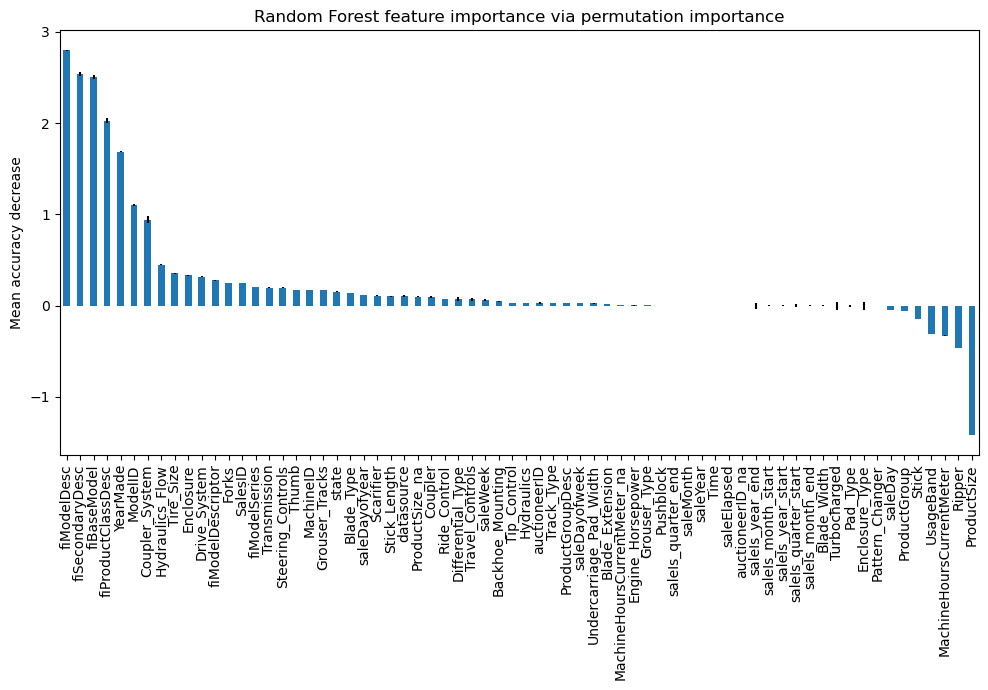

In [367]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [368]:
#lets get rid of all importences <0 (because Time is 0 and we need it for the boosted hybrid model)
columns_to_keep=forest_importances[forest_importances>=0].index.values

In [369]:
#lets drop em in the train and validation set
xs_perm = xs[columns_to_keep].copy()
valid_xs_perm= valid_xs[columns_to_keep].copy()

### Lets see if we can drop any corelated columns

In [370]:
def get_score(col_to_drop=None):
    hm.fit(xs_linreg,xs_perm.drop(col_to_drop,axis=1),y)
    preds=hm.predict(valid_xs_linreg,valid_xs_perm.drop(col_to_drop,axis=1),valid_y,False)
    print(f'{col_to_drop}: {r_mse(preds, valid_y)}')

In [377]:
ut.get_correlated_columns(xs_perm,correlation_threshold=.99)

[('fiBaseModel', 'fiModelDesc'),
 ('saleWeek', 'saleDayofyear'),
 ('saleMonth', 'saleDayofyear'),
 ('saleMonth', 'saleWeek'),
 ('saleElapsed', 'Time')]

## Not bad, and this is before we do any other data augmentaton or hyperparameter tuning using Optuna

<mark>Also this score would place at 15th out of 474 teams IFF our validation set is like the test set that only Kaggle has.


In [378]:
#there are a bunch,lets drop 1 at a time and see how our score is affected
for col in [ 'fiModelDesc','saleElapsed']:
    get_score(col)

fiModelDesc: 0.25213
saleElapsed: 0.253519


In [379]:
xs_perm.drop(columns=['fiModelDesc','saleElapsed'],inplace=True)
valid_xs_perm.drop(columns=['fiModelDesc','saleElapsed'],inplace=True)

In [380]:
hm.fit(xs_linreg,xs_perm,y)
preds=hm.predict(valid_xs_linreg,valid_xs_perm,valid_y,False)
print(f' {r_mse(preds, valid_y)}')

 0.252466


### Maybe we can fine tune the catboost regressor?

In [135]:
#see what we have now, helps set ranges for optuna
# hm.model_2.get_all_params()

In [381]:
%%time
from sklearn.metrics import mean_squared_error
import optuna
import sklearn
def objective(trial):
    #these are the parameters I want to optimize
    params = {
        'learning_rate':trial.suggest_discrete_uniform("learning_rate", 0.001, 0.11, 0.001),
        'depth': trial.suggest_int("depth", 1, 12),
        'l2_leaf_reg':trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'iterations':1000,
        'silent':True,
        'random_state':42
    }
 
    # Define the model. Pass in params to be tuned
    clf=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(**params), num_lags=0)
    
    #fit it
    clf.fit(xs_linreg,xs_perm,y)
    
    #get preds
    preds=clf.predict(valid_xs_linreg,valid_xs_perm,valid_y,False)

    return r_mse(preds,valid_y)
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('root_mean_squared_error: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-04-21 01:24:31,541] A new study created in memory with name: no-name-3ad191f9-79a4-45c3-8087-2f4ad85eb68b
[I 2023-04-21 01:24:37,449] Trial 0 finished with value: 0.326281 and parameters: {'learning_rate': 0.022000000000000002, 'depth': 4, 'l2_leaf_reg': 2.5}. Best is trial 0 with value: 0.326281.
[I 2023-04-21 01:24:51,579] Trial 1 finished with value: 0.243452 and parameters: {'learning_rate': 0.082, 'depth': 9, 'l2_leaf_reg': 4.5}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:25:03,435] Trial 2 finished with value: 0.244747 and parameters: {'learning_rate': 0.10500000000000001, 'depth': 8, 'l2_leaf_reg': 5.0}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:26:02,068] Trial 3 finished with value: 0.292664 and parameters: {'learning_rate': 0.006, 'depth': 12, 'l2_leaf_reg': 2.5}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:26:40,025] Trial 4 finished with value: 0.258431 and parameters: {'learning_rate': 0.02, 'depth': 11, 'l2_leaf_reg': 3.5}. Best

root_mean_squared_error: 0.243452
Best hyperparameters: {'learning_rate': 0.082, 'depth': 9, 'l2_leaf_reg': 4.5}
CPU times: user 25min 58s, sys: 14.1 s, total: 26min 12s
Wall time: 2min 8s


In [44]:
#plug these into model above and try again
trial.params

{'learning_rate': 0.065, 'depth': 11, 'l2_leaf_reg': 5.0}

In [382]:
#not satisfied?  Keep on optimizing from where you left off above
study.optimize(objective, n_trials=10)

[I 2023-04-21 01:27:08,414] Trial 5 finished with value: 0.282916 and parameters: {'learning_rate': 0.068, 'depth': 4, 'l2_leaf_reg': 3.0}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:27:19,920] Trial 6 finished with value: 0.306964 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 8, 'l2_leaf_reg': 3.0}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:27:25,713] Trial 7 finished with value: 0.470479 and parameters: {'learning_rate': 0.003, 'depth': 3, 'l2_leaf_reg': 2.0}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:27:35,259] Trial 8 finished with value: 0.259424 and parameters: {'learning_rate': 0.054, 'depth': 7, 'l2_leaf_reg': 5.0}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:27:47,067] Trial 9 finished with value: 0.249011 and parameters: {'learning_rate': 0.067, 'depth': 8, 'l2_leaf_reg': 4.5}. Best is trial 1 with value: 0.243452.
[I 2023-04-21 01:27:51,360] Trial 10 finished with value: 0.381498 and parameters: {'learning_r

In [46]:
#plug these into model above and try again
trial.params

{'learning_rate': 0.065, 'depth': 11, 'l2_leaf_reg': 5.0}

## The best score from above Optuna run is .241556

<mark>This is pretty good given the best Kaggle score is .22909.  This score would put us in 24th place

## How would a plain boosted tree do?

In [389]:
from catboost import CatBoostRegressor
clf1 = CatBoostRegressor(**trial.params,silent=True, random_state=42)
clf1.fit(xs_perm,y)
preds1=clf1.predict(valid_xs_perm)
r_mse(preds1,valid_y)

0.244155

## How about a random Forest?

In [388]:
from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=100, random_state=42)
clf2.fit(xs_perm, y)
preds2=clf2.predict(valid_xs_perm)
r_mse(preds2,valid_y)

0.244155

## Whats next? 

Making several models and averageing their results.  This is called bagging.  The problem is that we dont want to combine a Boosted tree with a random forest since the boosted tree is usually a little better so the random forest will probably just make things worse.

A better idea is to average 2 different kinds of models, like a neural network and a boosted tree.  But thats a topic for another class